## Testing Notebook


In [ ]:
%load_ext autoreload
%autoreload 2

from pprint import pprint

import matplotlib.pyplot as plt

from fibsem import acquire, patterning, utils
from fibsem.structures import BeamType

microscope, settings = utils.setup_session()

In [ ]:
## apply configuration

microscope.apply_configuration()


electron = microscope.get_beam_system_settings(beam_type=BeamType.ELECTRON)
pprint(electron.to_dict())

ion = microscope.get_beam_system_settings(beam_type=BeamType.ION)
pprint(ion.to_dict())



In [ ]:
# flat to beams
microscope.move_flat_to_beam(beam_type=BeamType.ELECTRON)

In [ ]:
microscope.move_flat_to_beam(beam_type=BeamType.ION)

In [ ]:
state = microscope.get_microscope_state()

pprint(state.to_dict())

In [ ]:
# move to state
microscope.set_microscope_state(state)

In [ ]:
## manipulator

microscope.insert_manipulator("PARK")


settings.image.hfw = 400e-6
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")

plt.show()


In [ ]:

from autolamella.workflows import actions

actions.move_needle_to_liftout_position(microscope)

settings.image.hfw = 400e-6
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")

plt.show()


In [ ]:
microscope.move_manipulator_corrected(dx=10e-6, dy=10e-6, beam_type=BeamType.ELECTRON)

settings.image.hfw = 400e-6
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")

plt.show()

microscope.move_manipulator_corrected(dx=10e-6, dy=10e-6, beam_type=BeamType.ION)

settings.image.hfw = 400e-6
eb_image, ib_image = acquire.take_reference_images(microscope, settings.image)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(eb_image.data, cmap="gray")
ax[1].imshow(ib_image.data, cmap="gray")

plt.show()

In [ ]:
# chamber camera
image = microscope.acquire_chamber_image()

plt.imshow(image.data, cmap="gray")
plt.show()


In [ ]:
# waffle dry run - full

# serial liftout - prep, mill trench, liftout

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2024-09-05 13:39:14,750 — root — INFO — connect_to_microscope:5355 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2024-09-05 13:39:14,750 — root — INFO — setup_session:217 — Finished setup for session: demo_2024-09-05-01-39-14PM
2024-09-05 13:39:14,750 — root — INFO — acquire_image:5372 — acquiring new ELECTRON image.
2024-09-05 13:39:14,755 — root — INFO — __init__:1633 — data.dtype:uint8, data.shape:(2048, 3072), data.ndim:2
Point(x=298, y=1198, name=None)
Shifting beam by -2.0149739583333333e-05, -2.8320312500000002e-06


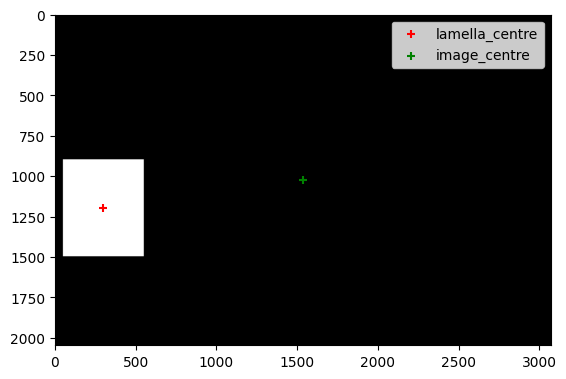

In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from adaptive_polish import gis_measurement as gm

from fibsem import acquire, conversions, utils
from fibsem.detection.detection import AdaptiveLamellaCentre
from fibsem.structures import BeamType

SIM_NO_MODEL = True

# connect to microscope
microscope, settings = utils.setup_session()

# load model
if not SIM_NO_MODEL:
    model_path = ""
    gm.init_model_with_path(model_path)


# acquire image
settings.image.resolution = [3072, 2048]
settings.image.hfw = 50e-6
settings.image.beam_type = BeamType.ELECTRON
image = acquire.acquire_image(microscope, settings.image)


LAMELLA_CLASS_IDX = 2
# segment, lamella class: idx == 2
if not SIM_NO_MODEL:
    pred = gm.segment(image.data)
else:
    # create a rectangle mask 250x175 pixels at a random position
    mask = np.zeros_like(image.data)
    shape = image.data.shape
    size_x, size_y = 500, 600
    x, y = np.random.randint(0, shape[1] - size_x), np.random.randint(0, shape[0] - size_y)
    mask[y:y+size_y, x:x+size_x] = 2
    pred = mask

# detect
feature = AdaptiveLamellaCentre()
centre_px = feature.detect(image.data, pred, None)

# convert to microscope image coordinates (0, 0 at centre of image)
centre_m = conversions.image_to_microscope_image_coordinates(
    centre_px, image.data, image.metadata.pixel_size.x
)
print(centre_px)
# shift beam
dx, dy = centre_m.x, centre_m.y
print(f"Shifting beam by {dx}, {dy}")
microscope.beam_shift(dx, dy, settings.image.beam_type)

# plot
plt.imshow(pred, cmap="gray")
plt.scatter(centre_px.x, centre_px.y, c="r", marker="+", label="lamella_centre")
plt.scatter(shape[1]//2, shape[0]//2, c="g", marker="+", label="image_centre")
plt.legend()
plt.show()


In [6]:
# beam shift alignment
import matplotlib.pyplot as plt
from adaptive_polish import gis_measurement as gm

from fibsem import acquire, conversions, utils
from fibsem.detection.detection import AdaptiveLamellaCentre
from fibsem.structures import BeamType

# connect to microscope
PROTOCOL_PATH = "path/to/adaptive-polish-protocol.yaml"
microscope, settings = utils.setup_session(protocol_path=PROTOCOL_PATH)

# load model
adaptive_polish_protocol = settings.protocol["milling"]["adaptive_polish"]
gm.init_model_with_path(adaptive_polish_protocol["model_path"])

# acquire image
settings.image.resolution = adaptive_polish_protocol["electron"]["resolution"]
settings.image.hfw = adaptive_polish_protocol["electron"]["hfw"]
settings.image.beam_type = BeamType.ELECTRON
image = acquire.acquire_image(microscope, settings.image)

# segment, lamella class: idx == 2
LAMELLA_CLASS_IDX = 2
pred = gm.segment(image.data)

# detect
feature = AdaptiveLamellaCentre()
centre_px = feature.detect(image.data, pred, None)

# convert to microscope image coordinates (0, 0 at centre of image)
centre_m = conversions.image_to_microscope_image_coordinates(
    centre_px, image.data, image.metadata.pixel_size.x
)

# shift beam
dx, dy = centre_m.x, centre_m.y
microscope.beam_shift(dx, dy, settings.image.beam_type)

# plot
plt.imshow(pred, cmap="gray")
plt.scatter(centre_px.x, centre_px.y, c="r", marker="+", label="lamella_centre")
plt.scatter(shape[1]//2, shape[0]//2, c="g", marker="+", label="image_centre")
plt.legend()
plt.show()

2024-09-05 13:33:09,511 — root — INFO — connect_to_microscope:5355 — Microscope client connected to DemoMicroscope with serial number 123456 and software version 0.1
2024-09-05 13:33:09,511 — root — INFO — setup_session:217 — Finished setup for session: demo_2024-09-05-01-33-09PM


KeyError: 'milling'